<a href="https://colab.research.google.com/github/MohammedHamood/IMDBReviews/blob/main/IMDBReviews_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMDB Reviews - Support Vector Machines

## Data Pre-Processing

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import preprocessingNLP as PNLP
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import Normalizer

# Import Dataset
print("Downloading Dataset ...")
!wget -nv "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
!tar -xf aclImdb_v1.tar.gz
IMDB_train = load_files('aclImdb/train/', categories=("pos", "neg"), encoding='utf-8')
IMDB_test = load_files('aclImdb/test/', categories=('pos', 'neg'), encoding='utf-8')
print("Dataset Downloaded")

# Preprocessing
print("PREPROCESSING ...")
IMDB_train.data = PNLP.customNLP(IMDB_train.data)
IMDB_test.data = PNLP.customNLP(IMDB_test.data)
IMDB_train.data, IMDB_train.target = PNLP.removeEmptyInstances(IMDB_train.data, IMDB_train.target)
print("PREPROCESSING DONE!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
2020-03-10 17:10:41 URL:http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz [84125825/84125825] -> "aclImdb_v1.tar.gz" [1]
Dataset Downloaded
PREPROCESSING ...
PREPROCESSING DONE!


## Setting Hyper-Parameters

In the following section, RandomSearchCV will be used to evaluate the validation accuracy of Support Vector Machines based on random combinations of hyper-parameters used in the validation pipeline. The relevant parameters needed are ngram_range for CountVectorizer and use_idf for TfidfTransformer. LinearSVC is used with its default attributes.

In [ ]:
# Set possible parameters
parameters = {
    'vect__ngram_range': ((1, 1), (1, 2),(1, 3)), 
    'tfidf__use_idf': (True, False),
}

# Create a pipeline
pip = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                ('Norm', Normalizer(copy=False)),('clf', LinearSVC())])

# Initialize RandomizedSearchCV
n_iter_search = 6
cv_folds = 3
SVM_rand_search = RandomizedSearchCV(pip, param_distributions=parameters, 
                               n_iter=n_iter_search, cv=cv_folds)

# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("Mean Fit Time: %.3f seconds" %results['mean_fit_time'][candidate])
            print("")

# Execute RandomizedSearchCV and print best results
SVM_rand_search.fit(IMDB_train.data, IMDB_train.target)
report(SVM_rand_search.cv_results_)

Model with rank: 1
Mean validation score: 0.891 (std: 0.002)
Parameters: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': True}
Mean Fit Time: 12.008 seconds

Model with rank: 2
Mean validation score: 0.887 (std: 0.002)
Parameters: {'vect__ngram_range': (1, 3), 'tfidf__use_idf': True}
Mean Fit Time: 26.106 seconds

Model with rank: 3
Mean validation score: 0.883 (std: 0.003)
Parameters: {'vect__ngram_range': (1, 2), 'tfidf__use_idf': False}
Mean Fit Time: 10.167 seconds

Model with rank: 4
Mean validation score: 0.881 (std: 0.002)
Parameters: {'vect__ngram_range': (1, 3), 'tfidf__use_idf': False}
Mean Fit Time: 22.947 seconds

Model with rank: 5
Mean validation score: 0.880 (std: 0.004)
Parameters: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': True}
Mean Fit Time: 2.153 seconds

Model with rank: 6
Mean validation score: 0.877 (std: 0.002)
Parameters: {'vect__ngram_range': (1, 1), 'tfidf__use_idf': False}
Mean Fit Time: 1.992 seconds



These results show a brief idea of the required parameters for CountVectorizer and TfidfTransformer.
RandomSearchCV constantly gives different rankings as it always chooses its parameters randomly. However, setting *use_idf=TRUE* for TfidfTransformer clearly seems to increase the mean validation set accuracy. This confirms that downscaling weights for words that occur in many documents improves the probability of obtaining the best accuracy. Additionally, it is a good idea to evaluate unigrams and bigrams for this model. *ngram_range=(1, 2)* will be used for CountVectorizer.

To avoid overfiting, a regularization method may be needed. In this section, the appropriate regularization method is evaluated. L1 and L2 regularizations are applied on multiple sizes of features and their corresponding validation accuracy are compared.

In [ ]:
# Create list of sample sizes
total_sample_size = len(IMDB_train.data)
sample_sizes = [total_sample_size/4 * i for i in range(1, 4)]

# Create pipelines
pip_l1 = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                   ('tfidf', TfidfTransformer(use_idf=True)),
                   ('Norm', Normalizer(copy=False)),
                   ('clf', LinearSVC(penalty='l1', dual=False))])
  
pip_l2 = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                   ('tfidf', TfidfTransformer(use_idf=True)),
                   ('Norm', Normalizer(copy=False)),
                   ('clf', LinearSVC(penalty='l2', dual=False))])

cv_folds=3
accuracies_l1 = []
accuracies_l2 = []
for size in sample_sizes:

  # Evaluate validation accuracy
  scores_l1 = cross_val_score(pip_l1, IMDB_train.data[:int(size)], IMDB_train.target[:int(size)], cv=cv_folds)
  scores_l2 = cross_val_score(pip_l2, IMDB_train.data[:int(size)], IMDB_train.target[:int(size)], cv=cv_folds)
  accuracies_l1.append(np.mean(scores_l1))
  accuracies_l2.append(np.mean(scores_l2))

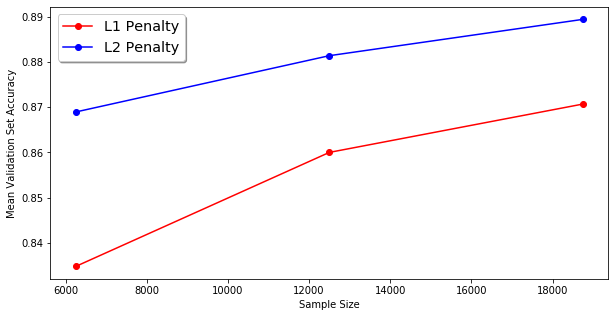

In [ ]:
#Display Results
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(sample_sizes, accuracies_l1, 'ro-', label='L1 Penalty')
ax1.plot(sample_sizes, accuracies_l2, 'bo-', label='L2 Penalty')
ax1.legend(loc='best', shadow=True, fontsize='x-large')
ax1.set_ylabel('Mean Validation Set Accuracy')
ax1.set_xlabel('Sample Size')
plt.show()

The previous graph displays the mean validation accuracy of Logistic Regression with L1 and L2 Regularization. L2 penalty seems to show better performance than L1. L2 penalty will be used as the optimal regularization method.

In the following section, GridSearchCV is used to properly detect the most optimal parameters needed to optimize the validation set accuracy of the Support Vector Machines Model: LinearSVC. Only the relevant parameters of the model are evaluated by combining different values for *C*, *tol* and *dual*.

In [ ]:
# Set relevant parameters
parameters = {
    'C': (0.1, 1, 10, 100),
    'tol': (0.1, 0.001, 0.00001),
    'dual': (True, False)
}

# Create a pipeline
pip = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=True)),
                ('Norm', Normalizer(copy=False)),
                ('clf', GridSearchCV(LinearSVC(penalty='l2'),
                                     parameters, cv=cv_folds, n_jobs=-1))])

# Execute pipeline
pip.fit(IMDB_train.data, IMDB_train.target)

# Collect and print results
test_accuracies = pip['clf'].cv_results_['mean_test_score']
test_time = pip['clf'].cv_results_['mean_fit_time']
test_params = pip['clf'].cv_results_['params']

for i in range(len(test_time)):
  print("Parameter: {0}".format(test_params[i]))
  print("Training Time: %.3f seconds" %test_time[i])
  print("Valdation Accuracy: {0:.3f}".format(test_accuracies[i]))
  print("")

print("Best Validation Set Accuracy: " + str(pip['clf'].best_score_))
print("Optimal Parameters: " + str(pip['clf'].best_params_))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Parameter: {'C': 0.1, 'dual': True, 'tol': 0.1}
Training Time: 0.701 seconds
Valdation Accuracy: 0.876

Parameter: {'C': 0.1, 'dual': True, 'tol': 0.001}
Training Time: 1.058 seconds
Valdation Accuracy: 0.876

Parameter: {'C': 0.1, 'dual': True, 'tol': 1e-05}
Training Time: 1.306 seconds
Valdation Accuracy: 0.876

Parameter: {'C': 0.1, 'dual': False, 'tol': 0.1}
Training Time: 2.046 seconds
Valdation Accuracy: 0.876

Parameter: {'C': 0.1, 'dual': False, 'tol': 0.001}
Training Time: 3.792 seconds
Valdation Accuracy: 0.876

Parameter: {'C': 0.1, 'dual': False, 'tol': 1e-05}
Training Time: 5.110 seconds
Valdation Accuracy: 0.876

Parameter: {'C': 1, 'dual': True, 'tol': 0.1}
Training Time: 1.055 seconds
Valdation Accuracy: 0.891

Parameter: {'C': 1, 'dual': True, 'tol': 0.001}
Training Time: 2.204 seconds
Valdation Accuracy: 0.891

Parameter: {'C': 1, 'dual': True, 'tol': 1e-05}
Training Time: 3.492 seconds
Valdation Accuracy: 0.891

Parameter: {'C': 1, 'dual': False, 'tol': 0.1}
Training

From these results, it seems that *C=100* is an optimal inverse regularization strength value as it gives the best accuracy when applying Ridge Regression. Furthermore, varying *tol* seems to make a big impact on the training time for the same validation set accuracy. *dual=True* with *tol=0.1* seems to be good values to find the best accuracy.

Increasing *C* could still improve the validation set accuracy. The next section analyses how *C* makes an impact on the accuracy.

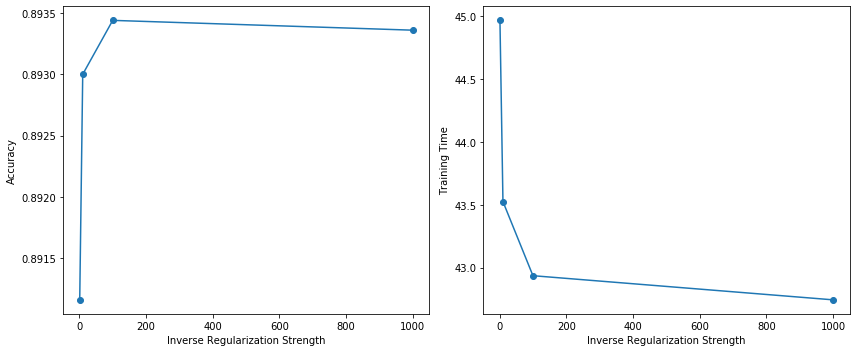

In [ ]:
# Create list of inverse regularization strengths (from 1 to 1000)
inv_reg_strengths = np.logspace(0, 3, 4)
accuracies = []
runtimes = []

# Evaluate validation set accuracy for each C
for c in inv_reg_strengths:

  # Create a pipeline
  pip = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=True)),
                ('Norm', Normalizer(copy=False)),
                ('clf', LinearSVC(penalty='l2', dual=True, tol=0.1, C=c))])

  # Evaluate validation set accuracy
  start = time.perf_counter()
  scores = cross_val_score(pip, IMDB_train.data, IMDB_train.target, cv=3)
  elapsed_time = time.perf_counter()-start
  accuracies.append(np.mean(scores))
  runtimes.append(elapsed_time)

#Display Results
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(inv_reg_strengths, accuracies, 'o-')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Inverse Regularization Strength')
ax2.plot(inv_reg_strengths, runtimes, 'o-')
ax2.set_ylabel('Training Time')
ax2.set_xlabel('Inverse Regularization Strength')
plt.tight_layout()
plt.show()

The previous graphs shows that the validation set accuracy seems to peak when *C=100*. This value will be used to evaluate the test set accuracy.

## Final Result

In [ ]:
# Create a pipeline
pip = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=True)),
                ('Norm', Normalizer(copy=False)),
                ('clf', LinearSVC(penalty='l2', dual=True, tol=0.1, C=40))])

# Evaluate validation set accuracy
start_time = time.time()
scores = cross_val_score(pip, IMDB_train.data, IMDB_train.target, cv=10)
valid_accuracy = np.mean(scores)
print("10-Cross Validation Runtime: %s seconds" % (time.time() - start_time))
print("Validation Set Accuracy: {0}".format(valid_accuracy))

# Fit the model
start_time = time.time()
pip.fit(IMDB_train.data, IMDB_train.target)
print("Training Runtime: %s seconds" % (time.time() - start_time))

# Get prediction on test set
start_time = time.time()
IMDB_pred = pip.predict(IMDB_test.data)
print("Prediction Runtime: %s seconds" % (time.time() - start_time))

# Compute test set accuracy
test_accuracy = np.mean(IMDB_pred==IMDB_test.target)
print("Test Set Accuracy: {0}".format(test_accuracy))

10-Cross Validation Runtime: 153.20181560516357 seconds
Validation Set Accuracy: 0.89876
Training Runtime: 16.825008869171143 seconds
Prediction Runtime: 6.59518575668335 seconds
Test Set Accuracy: 0.88536
